In [49]:
from modules.constants import SEED, TEST_DIR, TRAIN_DIR
from modules.aesthetic import Aesthetic
from modules.data_loader import DataLoader
from modules.preprocessor import Preprocessor
from modules.vectorizer import Vectorizer
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from typing import List

import numpy as np
import tensorflow as tf

## Deep Learning Techniques

In this notebook, different types of neural networks are trained to analyze whether such methodologies can achieve better accuracy compared to the machine learning models presented in the `ml` notebook. Below are the neural networks analyzed:
- BiLSTM
- Double BiLSTM
- CNN
- CNN + LSTM

For each neural network, the model that achieves the highest `val_accuracy` is saved, which will be used to make predictions on the `test` dataset. For the obtained models, fine-tuning was not performed, which could have led to better results (runned on mac M1).

In [2]:
data_loader = DataLoader(SEED)
preprocessor = Preprocessor(stopwords_language = 'english')
vectorizer = Vectorizer()

EMBEDDING_DIM = 100

In [3]:
X_train, y_train, X_val, y_val = data_loader.load_train_data(TRAIN_DIR, validation_split = 0.2, shuffle = True)
X_test, y_test = data_loader.load_test_data(TEST_DIR, shuffle = False)

X_train = [preprocessor.perform_soft_preprocessing(review.decode()) for review in X_train]
X_val = [preprocessor.perform_soft_preprocessing(review.decode()) for review in X_val]
X_test = [preprocessor.perform_soft_preprocessing(review.decode()) for review in X_test]

In [4]:
max_len = 557 # chosen from exploratory analysis (soft_preprocessing)
max_features = 20000

vectorize, _ = vectorizer.vectorize_data(X_train, output_mode = 'int', max_features = max_features)

X_train = vectorize.texts_to_sequences(X_train)
X_val = vectorize.texts_to_sequences(X_val)
X_test = vectorize.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train, maxlen = max_len)
X_val_padded = pad_sequences(X_val, maxlen = max_len)
X_test_padded = pad_sequences(X_test, maxlen = max_len)

In [22]:
def BILSTM(embedding_dim):
	return models.Sequential([
		layers.Embedding(input_dim = max_features, output_dim = embedding_dim, input_length = max_len),
		layers.Bidirectional(layers.LSTM(64)),
		layers.Dense(16, activation = 'relu'),
		layers.Dense(1, activation = 'sigmoid')
	])

def DOUBLE_BILSTM(embedding_dim):
	return models.Sequential([
		layers.Embedding(input_dim = max_features, output_dim = embedding_dim, input_length = max_len),
		layers.Bidirectional(layers.LSTM(64, return_sequences = True)),
		layers.Bidirectional(layers.LSTM(32)),
		layers.Dense(16, activation = 'relu'),
		layers.Dense(1, activation = 'sigmoid')
	])

def CNN(embedding_dim):
	return models.Sequential([
		layers.Embedding(input_dim = max_features, output_dim = embedding_dim, input_length = max_len),
		layers.Conv1D(128, 5, activation='relu'),
		layers.GlobalMaxPooling1D(),
		layers.Dense(16, activation = 'relu'),
		layers.Dense(1, activation = 'sigmoid')
	])

def CNN_LSTM(embedding_dim):
	return models.Sequential([
		layers.Embedding(max_features, output_dim = embedding_dim, input_length = max_len),
		layers.Dropout(0.2),
		layers.Conv1D(128, 5, activation = 'relu'),
		layers.MaxPooling1D(pool_size = 4),
		layers.LSTM(64, dropout = 0.2),
		layers.Dense(1, activation = 'sigmoid')
	])

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = False)

def train_model(
		X_train: List[str],
		y_train: List[int],
		X_val: List[str],
		y_val: List[int],
		model,
		model_name: str
	):

	model.compile(
		loss = tf.keras.losses.BinaryCrossentropy(),
		optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
		metrics = ['accuracy'],
	)

	checkpoint = tf.keras.callbacks.ModelCheckpoint(f'models/{model_name}.keras', monitor = "val_loss", mode = "min", save_best_only = True)	

	return model.fit(
		X_train, y_train,
		epochs = 10,
		validation_data = (X_val, y_val),
		callbacks = [
			early_stop,
			checkpoint
		]
	)

### BILSTM Model

In [7]:
bilstm = BILSTM(embedding_dim = EMBEDDING_DIM)
bilstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 557, 100)          2000000   
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2086561 (7.96 MB)
Trainable params: 2086561 (7.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
bilstm_history = train_model(X_train_padded, y_train, X_val_padded, y_val, bilstm, 'bilstm')

Epoch 1/10
625/625 [==============================] - 125s 199ms/step - loss: 0.5746 - accuracy: 0.6945 - val_loss: 0.3983 - val_accuracy: 0.8384
Epoch 2/10
625/625 [==============================] - 124s 198ms/step - loss: 0.2831 - accuracy: 0.8900 - val_loss: 0.2697 - val_accuracy: 0.8916
Epoch 3/10
625/625 [==============================] - 125s 199ms/step - loss: 0.1906 - accuracy: 0.9339 - val_loss: 0.2602 - val_accuracy: 0.8964
Epoch 4/10
625/625 [==============================] - 128s 205ms/step - loss: 0.1353 - accuracy: 0.9549 - val_loss: 0.2708 - val_accuracy: 0.8974
Epoch 5/10
625/625 [==============================] - 125s 199ms/step - loss: 0.0980 - accuracy: 0.9682 - val_loss: 0.3164 - val_accuracy: 0.8938
Epoch 6/10
625/625 [==============================] - 127s 203ms/step - loss: 0.0752 - accuracy: 0.9773 - val_loss: 0.3230 - val_accuracy: 0.8936


In [9]:
bilstm = tf.keras.models.load_model('models/bilstm.keras')
bilstm.evaluate(X_test_padded, y_test)

782/782 [==============================] - 44s 56ms/step - loss: 0.2905 - accuracy: 0.8796


[0.29048728942871094, 0.8795999884605408]

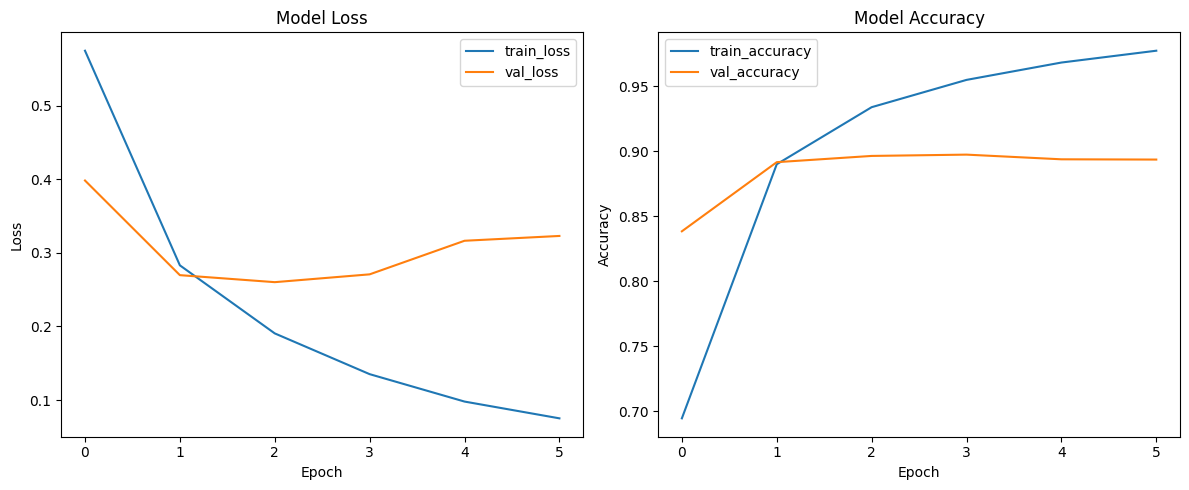

In [51]:
Aesthetic.plot_dl_history(bilstm_history)

### Double BILSTM Model

In [10]:
double_bilstm = DOUBLE_BILSTM(embedding_dim = EMBEDDING_DIM)
double_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 557, 100)          2000000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 557, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2126753 (8.11 MB)
Trainable params: 2126

In [11]:
double_bilstm_history = train_model(X_train_padded, y_train, X_val_padded, y_val, double_bilstm, 'double_bilstm')

Epoch 1/10
625/625 [==============================] - 201s 319ms/step - loss: 0.5024 - accuracy: 0.7347 - val_loss: 0.2953 - val_accuracy: 0.8818
Epoch 2/10
625/625 [==============================] - 194s 310ms/step - loss: 0.2295 - accuracy: 0.9125 - val_loss: 0.2521 - val_accuracy: 0.9000
Epoch 3/10
625/625 [==============================] - 192s 307ms/step - loss: 0.1438 - accuracy: 0.9526 - val_loss: 0.2734 - val_accuracy: 0.8952
Epoch 4/10
625/625 [==============================] - 191s 306ms/step - loss: 0.0885 - accuracy: 0.9735 - val_loss: 0.3307 - val_accuracy: 0.8918
Epoch 5/10
625/625 [==============================] - 192s 307ms/step - loss: 0.0559 - accuracy: 0.9859 - val_loss: 0.3993 - val_accuracy: 0.8822


In [52]:
double_bilstm = tf.keras.models.load_model('models/double_bilstm.keras')
double_bilstm.evaluate(X_test_padded, y_test)

782/782 [==============================] - 62s 79ms/step - loss: 0.2900 - accuracy: 0.8836


[0.2899875044822693, 0.8835600018501282]

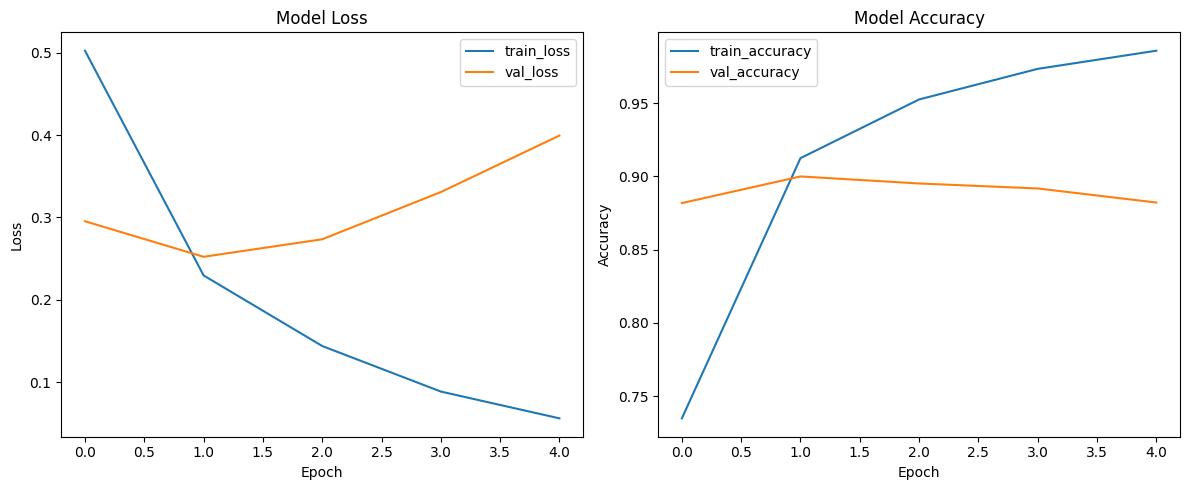

In [54]:
Aesthetic.plot_dl_history(double_bilstm_history)

### CNN Model

In [13]:
cnn = CNN(embedding_dim = EMBEDDING_DIM)
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 557, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 553, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2066209 (7.88 MB)
Trainable params: 2066209 (7.88 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [14]:
cnn_history = train_model(X_train_padded, y_train, X_val_padded, y_val, cnn, 'cnn')

Epoch 1/10
625/625 [==============================] - 28s 44ms/step - loss: 0.6793 - accuracy: 0.6380 - val_loss: 0.6367 - val_accuracy: 0.7418
Epoch 2/10
625/625 [==============================] - 29s 46ms/step - loss: 0.5448 - accuracy: 0.7546 - val_loss: 0.4754 - val_accuracy: 0.7846
Epoch 3/10
625/625 [==============================] - 31s 49ms/step - loss: 0.4019 - accuracy: 0.8250 - val_loss: 0.3774 - val_accuracy: 0.8348
Epoch 4/10
625/625 [==============================] - 29s 46ms/step - loss: 0.3085 - accuracy: 0.8745 - val_loss: 0.3217 - val_accuracy: 0.8636
Epoch 5/10
625/625 [==============================] - 29s 46ms/step - loss: 0.2383 - accuracy: 0.9132 - val_loss: 0.2862 - val_accuracy: 0.8790
Epoch 6/10
625/625 [==============================] - 29s 47ms/step - loss: 0.1833 - accuracy: 0.9391 - val_loss: 0.2646 - val_accuracy: 0.8908
Epoch 7/10
625/625 [==============================] - 29s 46ms/step - loss: 0.1382 - accuracy: 0.9596 - val_loss: 0.2543 - val_accuracy:

In [15]:
cnn = tf.keras.models.load_model('models/cnn.keras')
cnn.evaluate(X_test_padded, y_test)

782/782 [==============================] - 9s 12ms/step - loss: 0.2699 - accuracy: 0.8896


[0.2698759436607361, 0.8895999789237976]

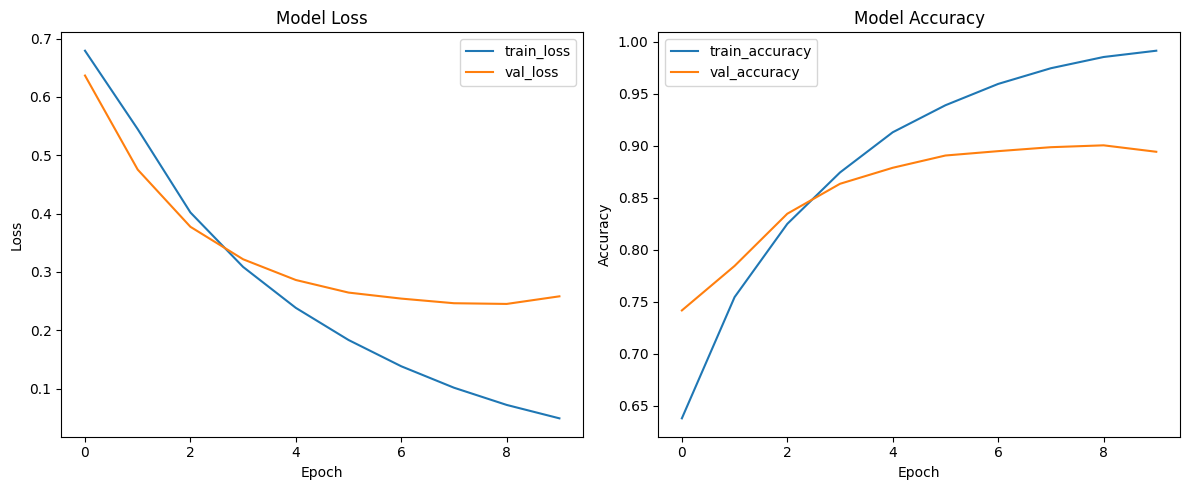

In [55]:
Aesthetic.plot_dl_history(cnn_history)

### CNN LSTM Model

In [23]:
cnn_lstm = CNN_LSTM(embedding_dim = EMBEDDING_DIM)
cnn_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 557, 100)          2000000   
                                                                 
 dropout_1 (Dropout)         (None, 557, 100)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 553, 128)          64128     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 138, 128)          0         
 g1D)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                      

In [24]:
cnn_lstm_history = train_model(X_train_padded, y_train, X_val_padded, y_val, cnn_lstm, 'cnn_lstm')

Epoch 1/10
625/625 [==============================] - 59s 93ms/step - loss: 0.5819 - accuracy: 0.6681 - val_loss: 0.3397 - val_accuracy: 0.8722
Epoch 2/10
625/625 [==============================] - 56s 89ms/step - loss: 0.2807 - accuracy: 0.8909 - val_loss: 0.2661 - val_accuracy: 0.8988
Epoch 3/10
625/625 [==============================] - 56s 90ms/step - loss: 0.1904 - accuracy: 0.9306 - val_loss: 0.2604 - val_accuracy: 0.8948
Epoch 4/10
625/625 [==============================] - 57s 91ms/step - loss: 0.1422 - accuracy: 0.9539 - val_loss: 0.2591 - val_accuracy: 0.8984
Epoch 5/10
625/625 [==============================] - 58s 92ms/step - loss: 0.1031 - accuracy: 0.9663 - val_loss: 0.2880 - val_accuracy: 0.8952
Epoch 6/10
625/625 [==============================] - 58s 93ms/step - loss: 0.0787 - accuracy: 0.9762 - val_loss: 0.2980 - val_accuracy: 0.8930
Epoch 7/10
625/625 [==============================] - 59s 94ms/step - loss: 0.0627 - accuracy: 0.9814 - val_loss: 0.3276 - val_accuracy:

In [25]:
cnn_lstm = tf.keras.models.load_model('models/cnn_lstm.keras')
cnn_lstm.evaluate(X_test_padded, y_test)

782/782 [==============================] - 19s 23ms/step - loss: 0.3068 - accuracy: 0.8736


[0.3068254590034485, 0.8735600113868713]

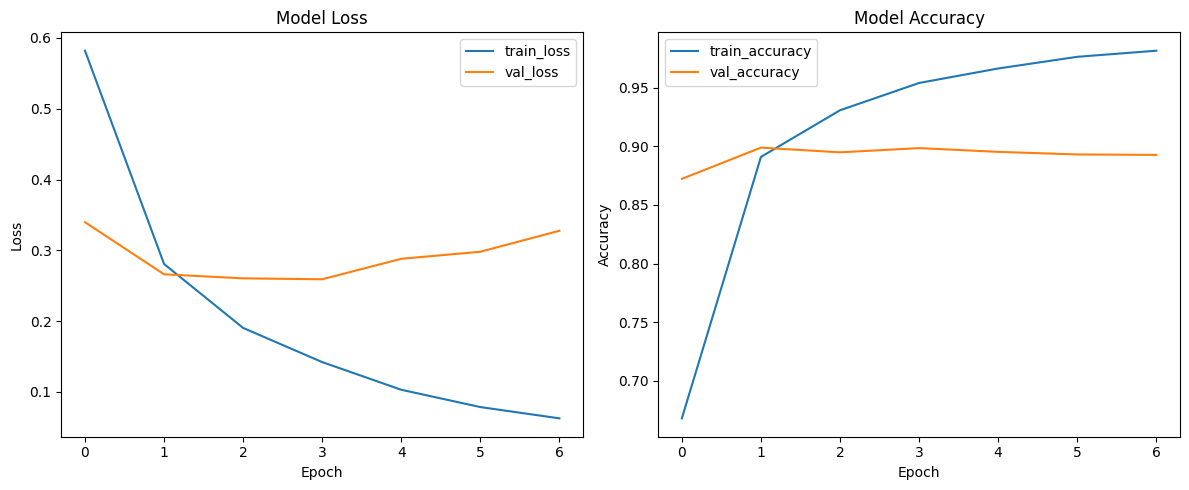

In [56]:
Aesthetic.plot_dl_history(cnn_lstm_history)

### Results

| Model  | Accuracy | 
| ------------- | ------------- |
| BiLSTM | 0.8796 |
| Double BiLSTM  | 0.8836|
| CNN  | <u>**0.8896**</u> |
| CNN + LSTM | 0.8736 |